In [76]:
import pandas as pd
import torch
import torch.nn as nn
import scipy.stats as sps
import copy
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from tqdm import tqdm
from typing import List
from matplotlib import cm
%load_ext autoreload
from models.Oracle_Predictor import OracleModel, dynamic_system_iterate_oracle
from models.Random_Predictor import RandomModel, dynamic_system_iterate_random
%autoreload 2
import seaborn as sns

sns.set_style("whitegrid")

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
print(device)

cpu


## Генерация синтетической выборки


In [78]:
c0 = 1
w0 = 0.1


def usefulness(c, w, noice):
    return  np.exp(-0.5 * ((c - c0)**2 +(w - w0)**2  + noice**2)) * 0.95
    # return np.arctan(c - w + noice) / np.pi + 0.5


def L(u_true, u_pred):
    return (u_true - u_pred) ** 2


customer_distribution = sps.norm(0.7, 0.3)
w_distribution = sps.norm(0, 0.6)

epsilon = sps.norm(0, 0.05)


In [79]:
from models.u_predictor import NeuralNetwork, FeedbackDataset
from models.u_predictor import dynamic_system_iterate_u
from models.u_predictor import init_data

In [92]:
start_c_size = 256
start_w_size = 256
z = lambda: epsilon.rvs()
train_data_loader, c_w_distribution = init_data(customer_distribution, w_distribution, start_c_size, start_w_size,
                                                usefulness, z)

In [93]:
def init_model():
    loss_func = torch.nn.BCELoss()
    model = NeuralNetwork(device, loss_func).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    model.set_optimizer(optimizer)
    model.set_scheduler(scheduler)
    loss_hist, _ = model.fit_epoch(train_data_loader)
    return model, loss_hist

In [94]:
num_of_iterations = 51

In [95]:
def execute_experiment(model, dynamic_system_iterate_f, c_w_distribution, num_of_iterations, freq=1, u_pred_case=1, topn=8):
    new_c_w_distr = copy.deepcopy(c_w_distribution)
    loss_history = []
    accuracy = []
    residual_history = []
    L_val = []
    mean_history = []
    variance_history = []
    c_size = 256
    w_size = 256
    fig, axs = plt.subplots(ncols=2)
    for i in tqdm(range(num_of_iterations)):
        z = lambda: epsilon.rvs()
        if i % freq == 0:
            new_c_w_distr, accuracy_at16, loss, L_mean, residual, mean, variance = dynamic_system_iterate_f(model, usefulness, z, L,
                                                                                                            new_c_w_distr,
                                                                                                            u_pred_case=u_pred_case,
                                                                                                            c_size=c_size,
                                                                                                            w_size=w_size, topn=topn,
                                                                                                            visualize_distributions=( i, axs))
        else:
            new_c_w_distr, accuracy_at16, loss, L_mean, residual, mean, variance = dynamic_system_iterate_f(model, usefulness, z, L,
                                                                                                            new_c_w_distr,
                                                                                                            u_pred_case=u_pred_case,
                                                                                                            c_size=c_size,
                                                                                                            w_size=w_size, topn=topn)
        loss_history.append(np.mean(loss))
        accuracy.append(accuracy_at16)
        residual_history.append(residual)
        L_val.append(L_mean)
        mean_history.append(mean)
        variance_history.append(variance)
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.show()
    return loss_history, accuracy, residual_history, L_val, mean_history, variance_history

## Запуск итераций для NN


In [96]:
model, loss_hist = init_model()
# loss_hist.extend(model.fit_epoch(train_data_loader)[0])

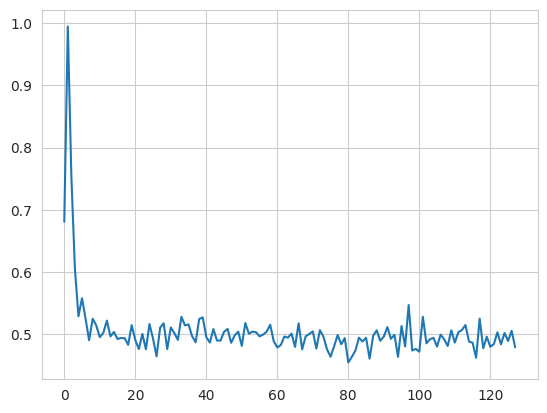

In [56]:
plt.plot(loss_hist)

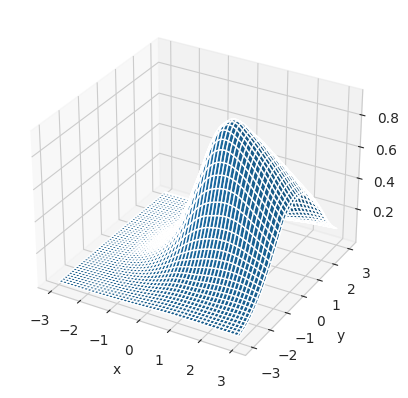

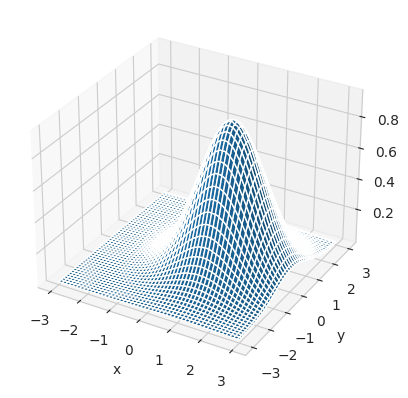

In [57]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
Z_true = []
points, u_pred = model.get_prediction_pair(x, y, u_pred_case=1)
for i, pos in enumerate(points):
    u_true = usefulness(pos[0], pos[1], z())
    Z_true.append(u_true)

model.print_3D(x, y, u_pred, Z_true)

100%|██████████| 51/51 [04:09<00:00,  4.90s/it]
/tmp/ipykernel_80896/1295006919.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


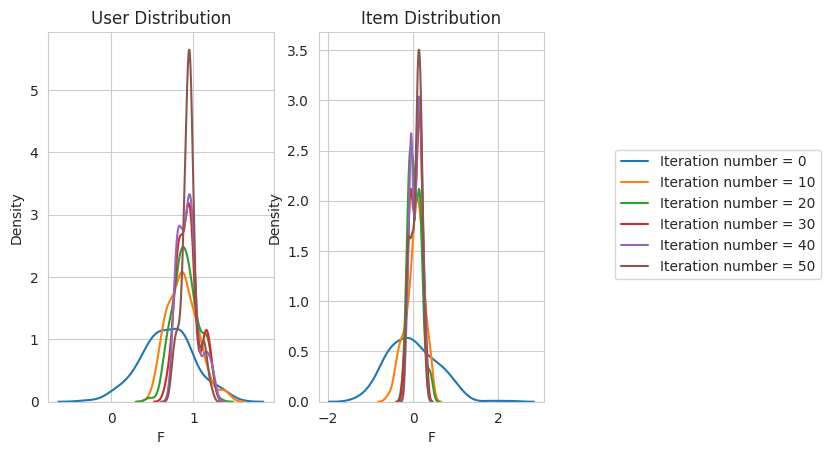

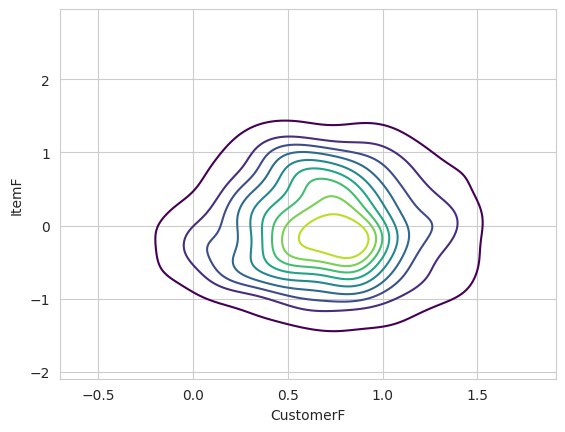

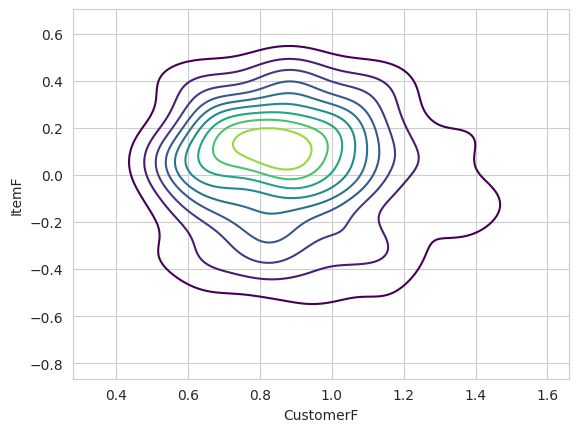

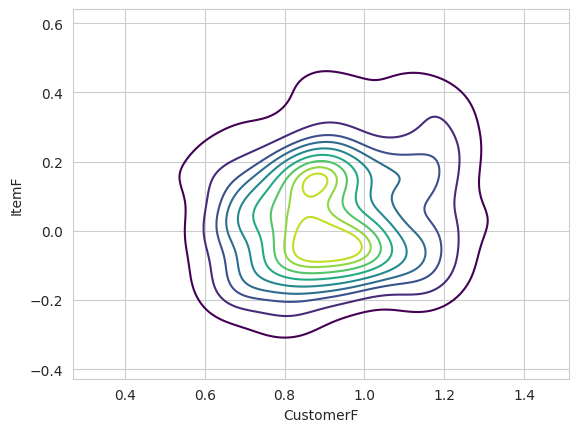

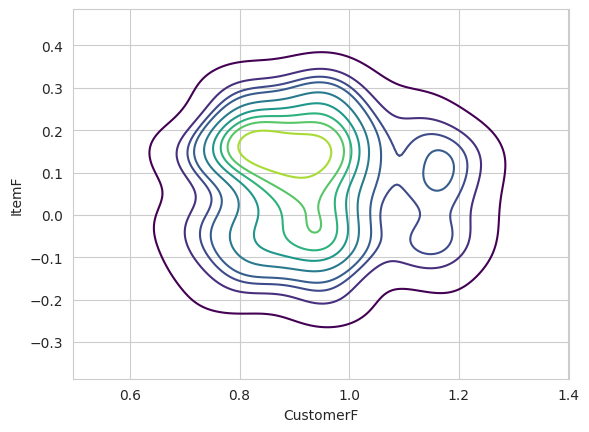

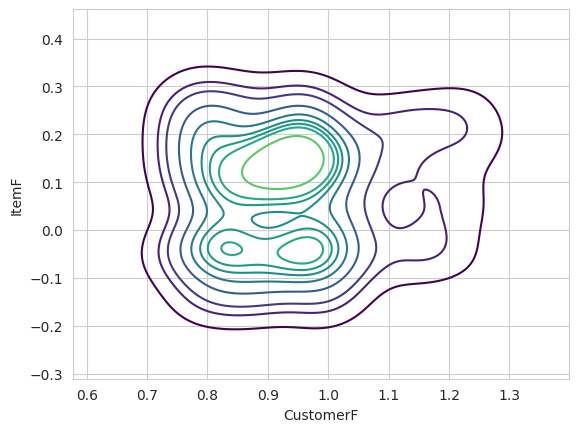

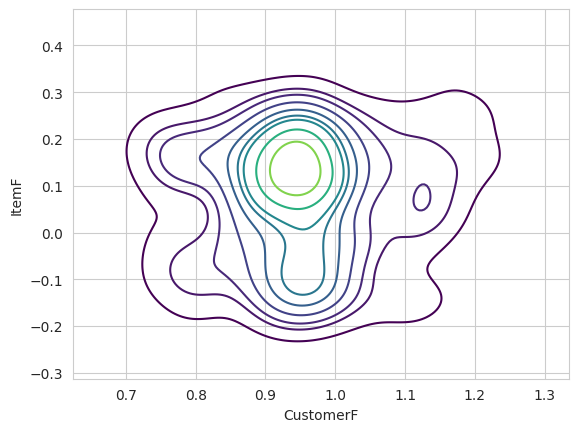

In [85]:
loss_history_2, accuracy_2, residual_history_2, L_val_2, mean_2, variance_2 = execute_experiment(model, dynamic_system_iterate_u, c_w_distribution, num_of_iterations, freq=10, u_pred_case=2)

In [91]:
model, _ = init_model()

KeyboardInterrupt: 

100%|██████████| 51/51 [04:05<00:00,  4.81s/it]
/tmp/ipykernel_80896/1295006919.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


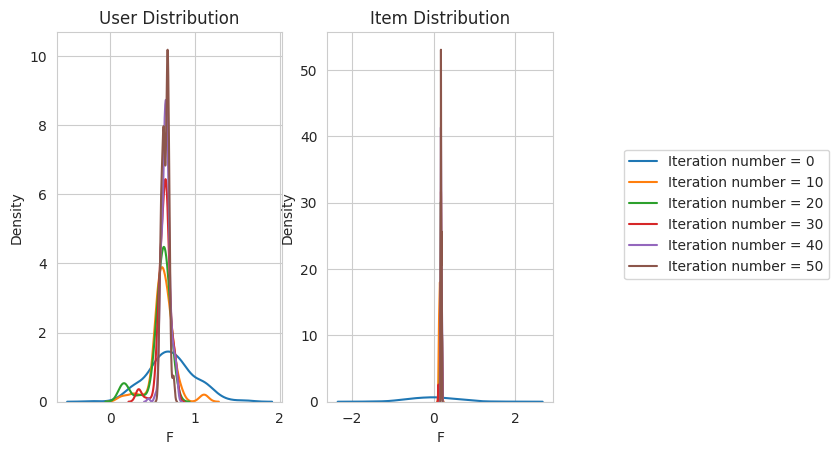

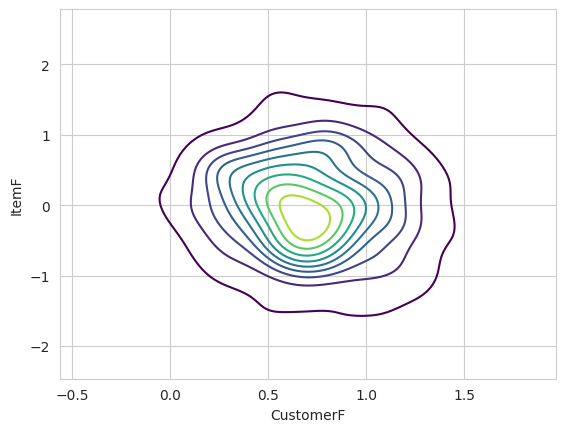

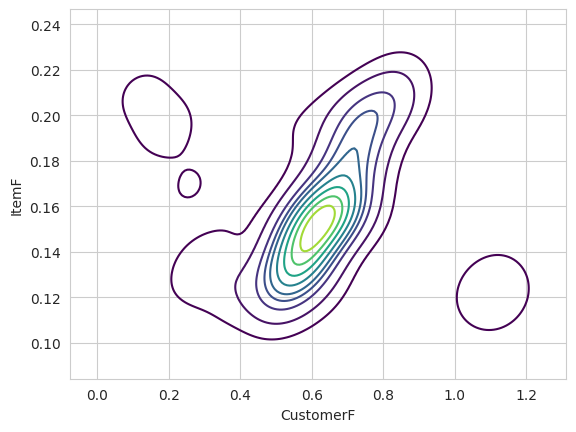

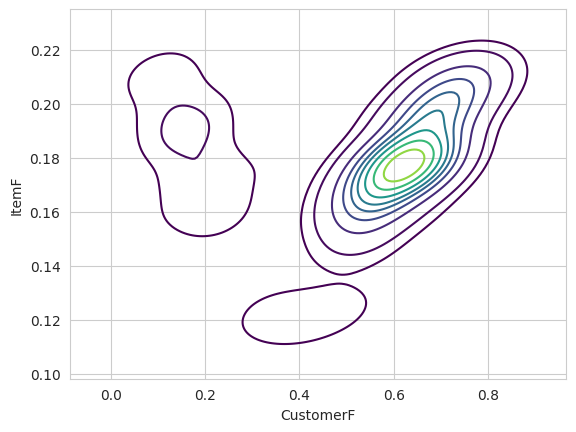

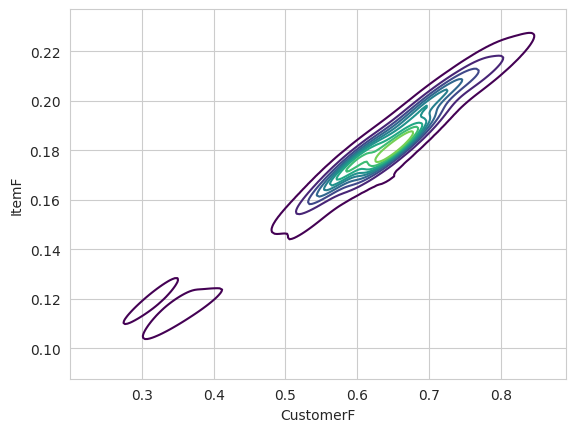

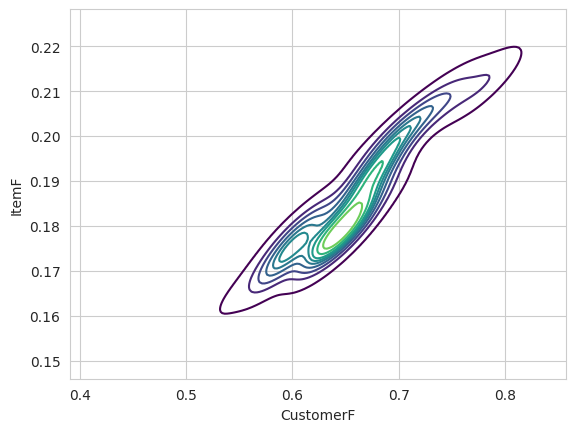

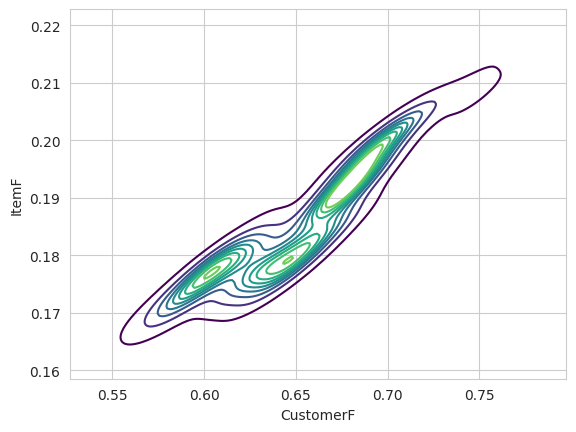

In [97]:
loss_history_1, accuracy_1, residual_history_1, L_val_1, mean_1, variance_1 = execute_experiment(model,dynamic_system_iterate_u,  c_w_distribution, num_of_iterations, freq=10, u_pred_case=1)

In [61]:
model = OracleModel()

100%|██████████| 51/51 [02:38<00:00,  3.12s/it]
/tmp/ipykernel_80896/1295006919.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


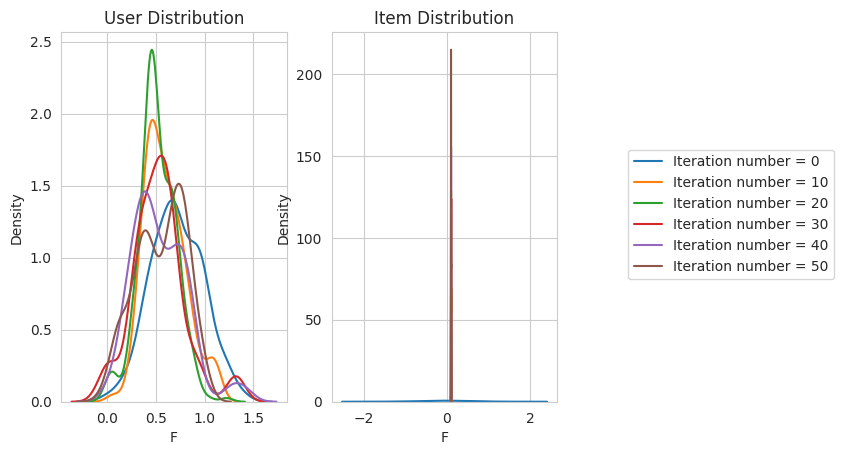

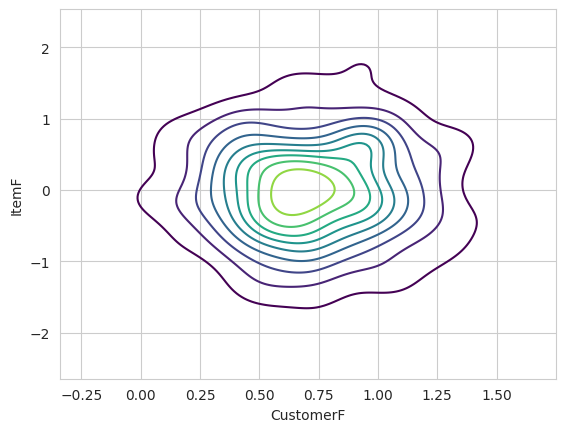

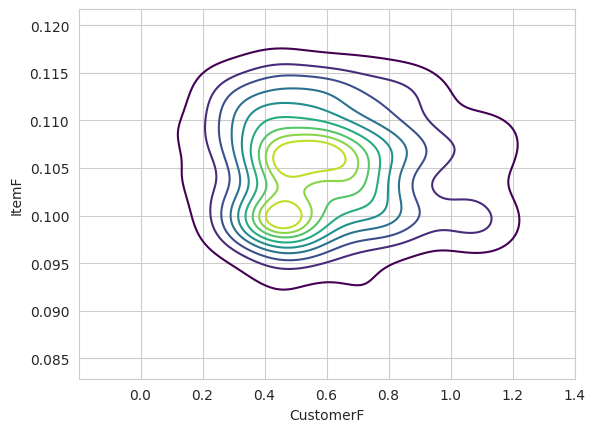

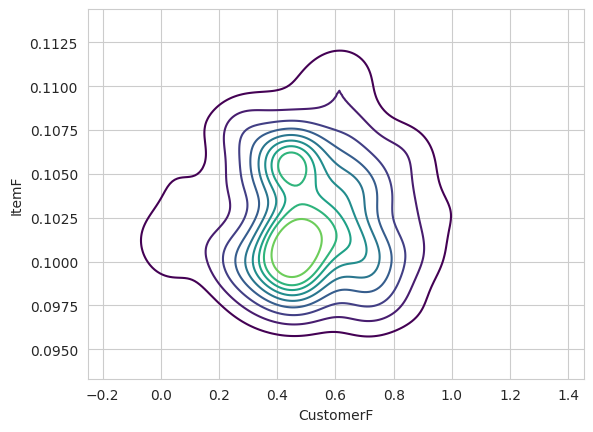

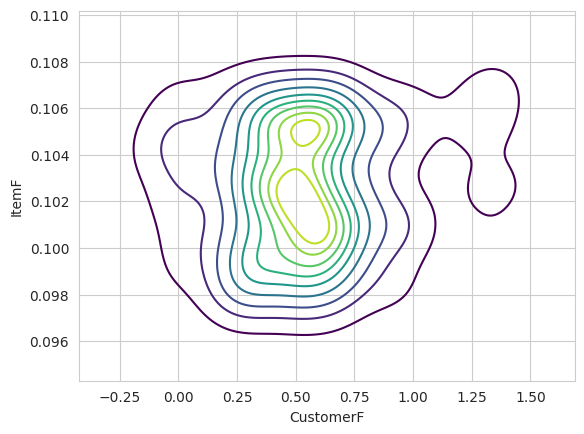

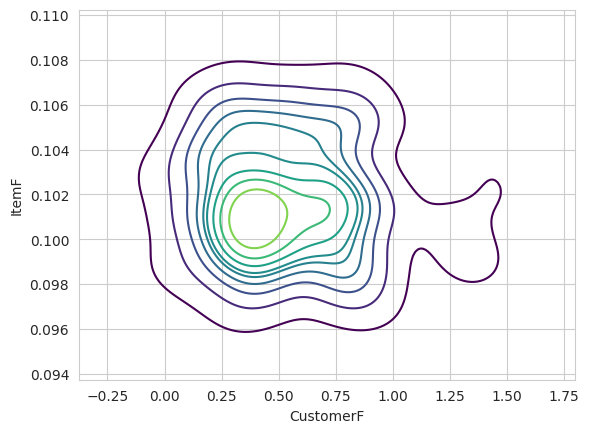

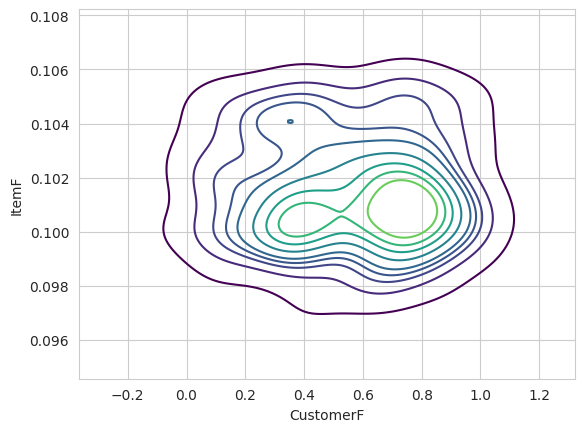

In [62]:
loss_history_oracle, accuracy_oracle, residual_history_oracle, L_val_oracle, mean_oracle, variance_oracle = execute_experiment(model, dynamic_system_iterate_oracle, c_w_distribution, num_of_iterations, freq=10, u_pred_case=1)

In [86]:
model = RandomModel(0.8)

100%|██████████| 51/51 [02:34<00:00,  3.02s/it]
/tmp/ipykernel_80896/1295006919.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


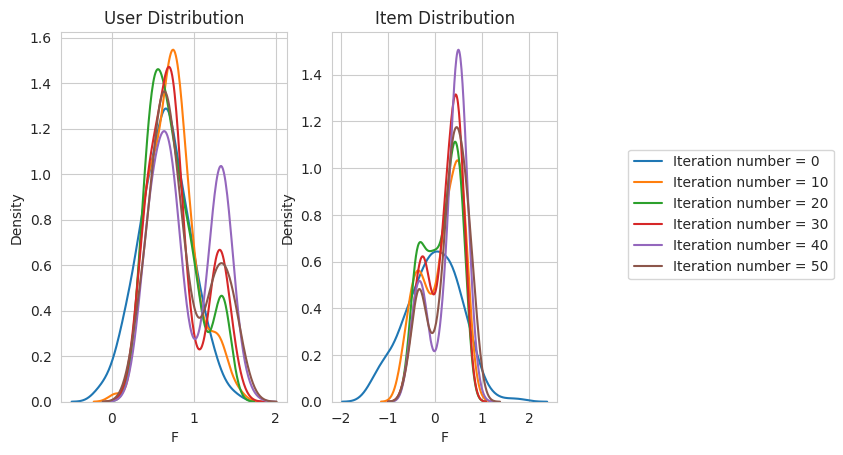

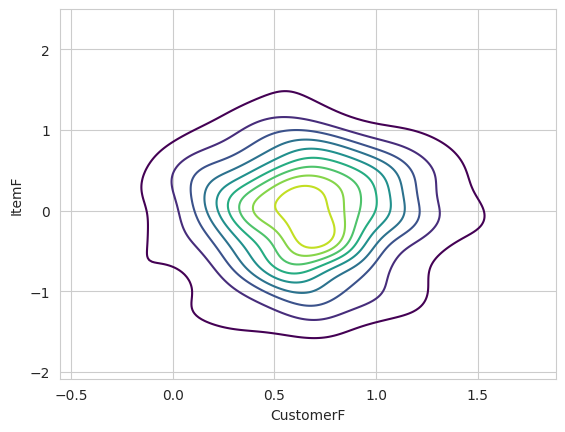

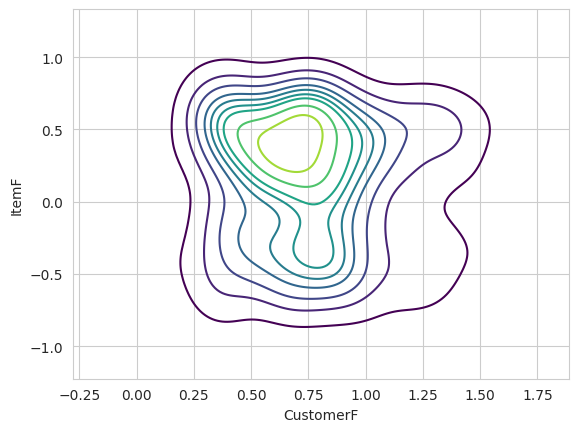

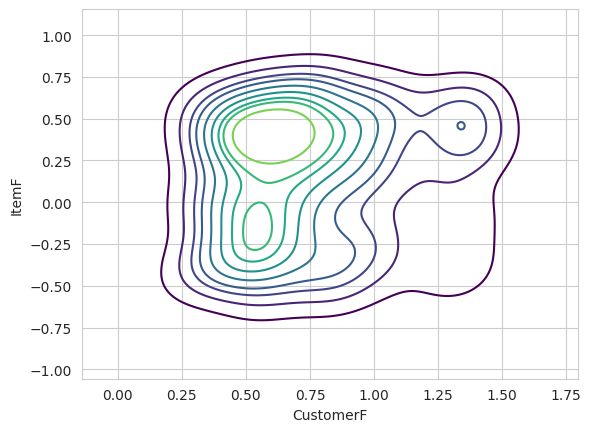

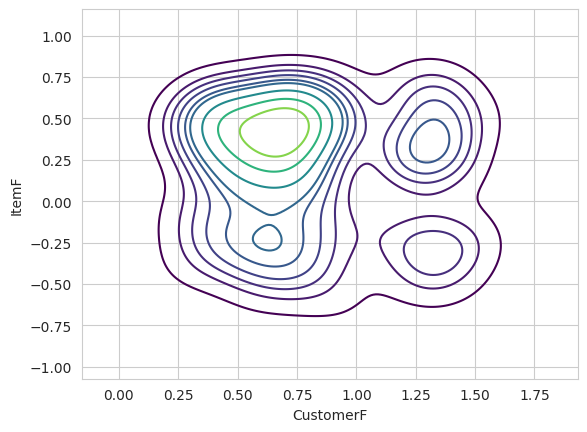

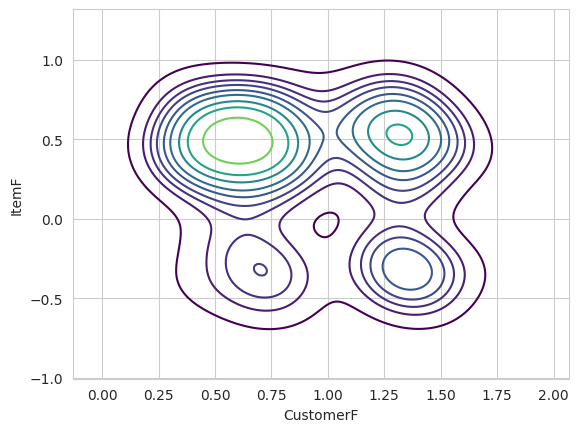

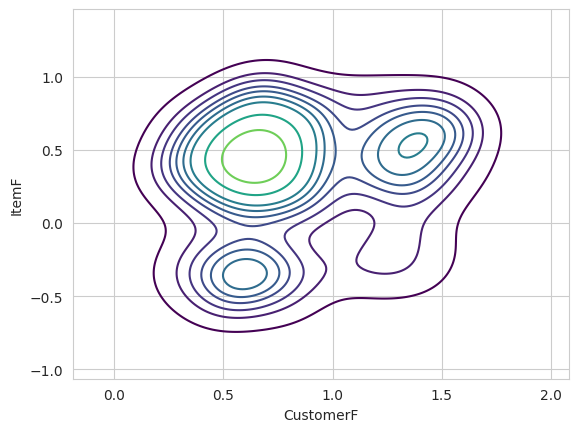

In [87]:
loss_history_random, accuracy_random, residual_history_random, L_val_random, mean_random, variance_random = execute_experiment(model, dynamic_system_iterate_random, c_w_distribution, num_of_iterations, freq=10, u_pred_case=1)

In [98]:
# variance_random = np.array(variance_random).T
mean_1 = np.array(mean_1).T
variance_1 = np.array(variance_1).T


In [67]:
mean_1 = np.array(mean_1).T
mean_2 = np.array(mean_2).T
mean_oracle = np.array(mean_oracle).T
variance_1 = np.array(variance_1).T
variance_2 = np.array(variance_2).T
variance_oracle = np.array(variance_oracle).T

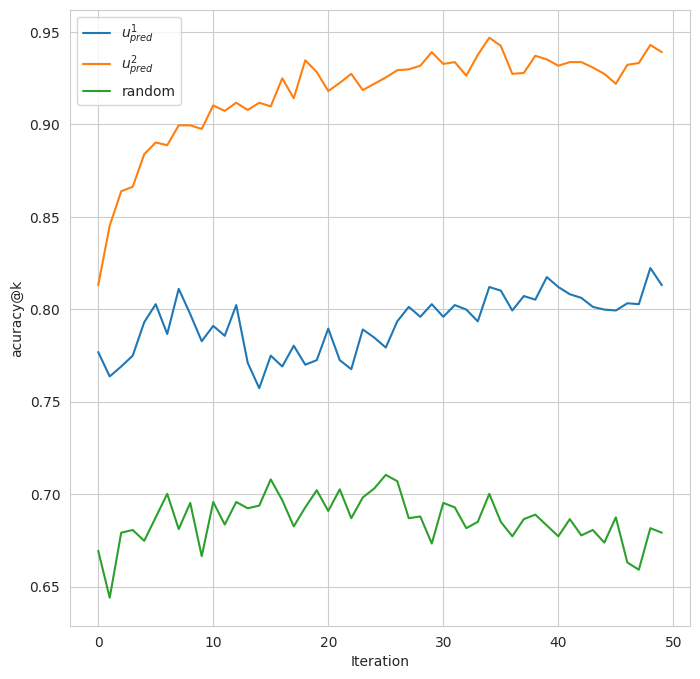

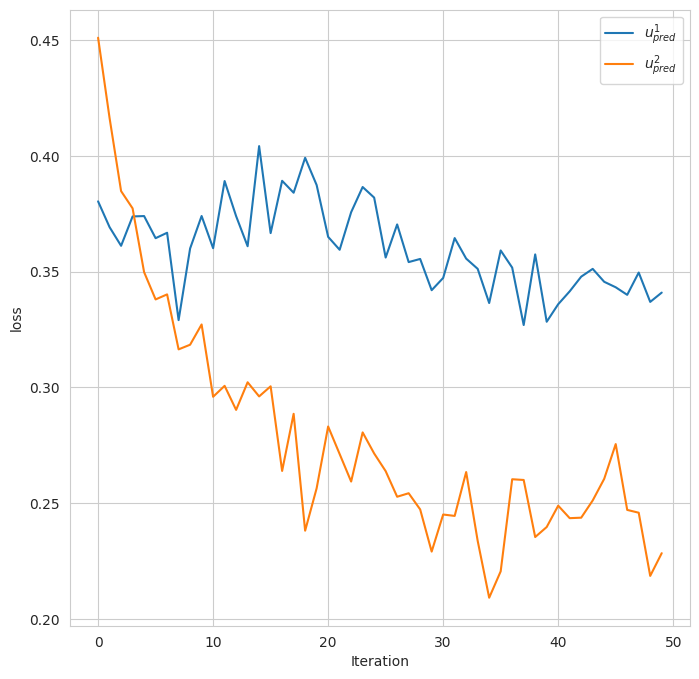

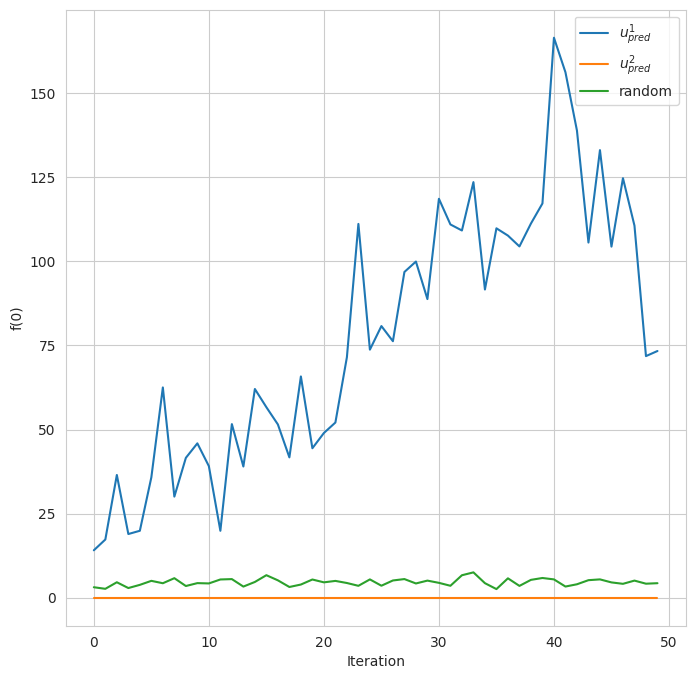

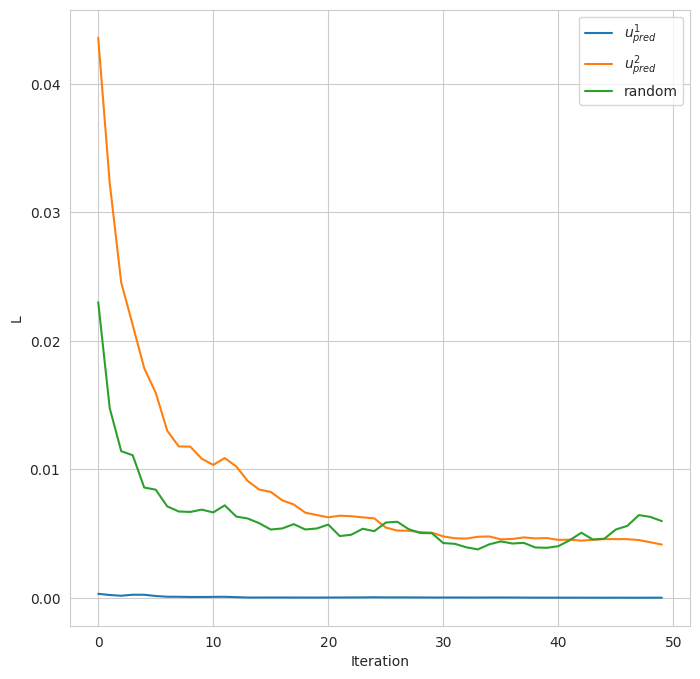

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


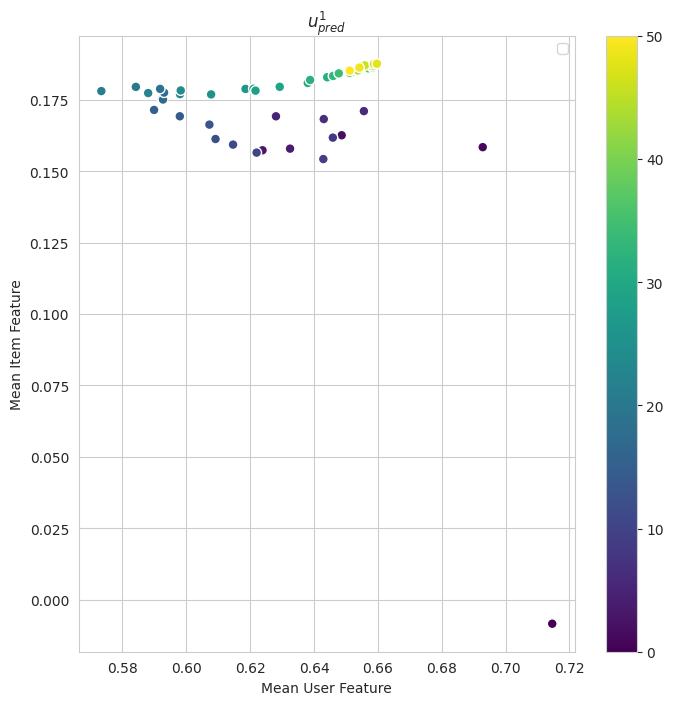

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


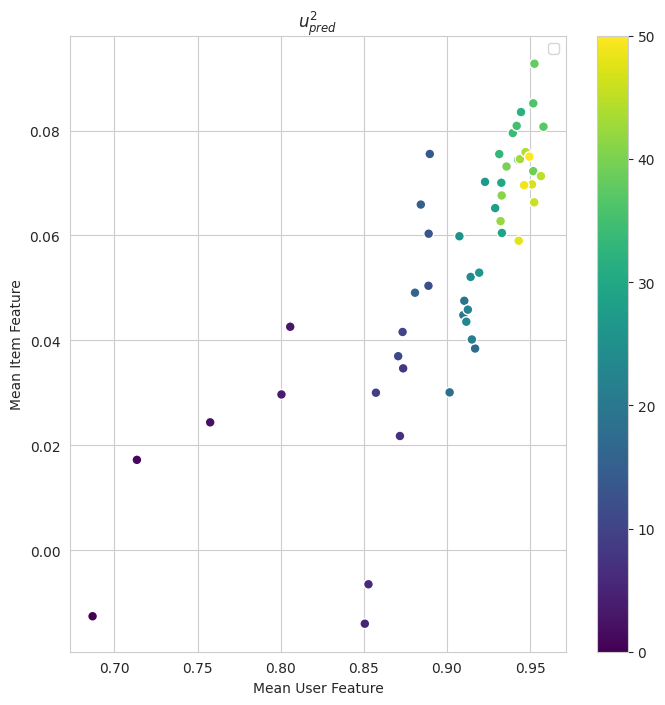

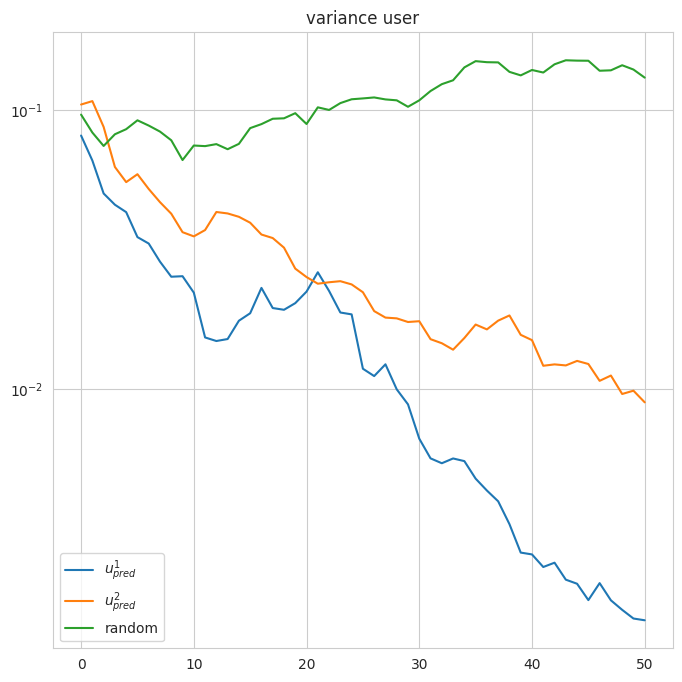

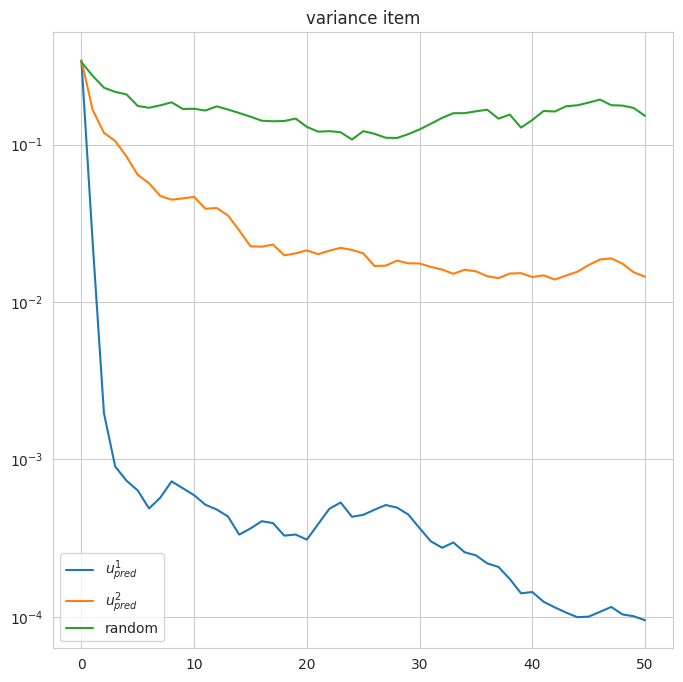

In [99]:
plt.figure(figsize=(8, 8))

plt.plot(accuracy_1[1:], label=r"$u^1_{pred}$")
plt.plot(accuracy_2[1:], label=r"$u^2_{pred}$")
# plt.plot(np.arange(num_of_iterations - 1), accuracy_oracle[1:], label="oracle")
plt.plot(accuracy_random[1:], label="random")

plt.xlabel("Iteration")
plt.ylabel("acuracy@k")
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))

plt.plot(np.arange(num_of_iterations - 1), loss_history_1[1:], label=r"$u^1_{pred}$")
plt.plot(np.arange(num_of_iterations - 1), loss_history_2[1:], label=r"$u^2_{pred}$")
# plt.plot(np.arange(num_of_iterations - 1), loss_history_oracle[1:], label="oracle")
# plt.plot(np.arange(num_of_iterations - 1), loss_history_random[1:], label="random")


plt.xlabel("Iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))


plt.plot(np.arange(num_of_iterations - 1), residual_history_1[1:], label=r"$u^1_{pred}$")
plt.plot(np.arange(num_of_iterations - 1), residual_history_2[1:], label=r"$u^2_{pred}$")
# plt.plot(np.arange(num_of_iterations - 1), residual_history_oracle[1:], label="oracle")
plt.plot(np.arange(num_of_iterations - 1), residual_history_random[1:], label="random")


plt.xlabel("Iteration")
plt.ylabel("f(0)")
plt.legend()
plt.show()


plt.figure(figsize=(8, 8))

plt.plot(np.arange(num_of_iterations - 1), L_val_1[1:], label=r"$u^1_{pred}$")
plt.plot(np.arange(num_of_iterations - 1), L_val_2[1:], label=r"$u^2_{pred}$")
# plt.plot(np.arange(num_of_iterations - 1), L_val_oracle[1:], label="oracle")
plt.plot(np.arange(num_of_iterations - 1), L_val_random[1:], label="random")


plt.xlabel("Iteration")
plt.ylabel("L")
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))
plt.title(r"$u^1_{pred}$")

plt.scatter(mean_1[0], mean_1[1], c=np.arange(num_of_iterations), cmap='viridis', edgecolors='w', s=50)
plt.xlabel("Mean User Feature")
plt.ylabel("Mean Item Feature")
plt.colorbar()

plt.legend()

plt.show()

plt.figure(figsize=(8, 8))
plt.title(r"$u^2_{pred}$")
plt.scatter(mean_2[0], mean_2[1], c=np.arange(num_of_iterations), cmap='viridis', edgecolors='w', s=50)
plt.xlabel("Mean User Feature")
plt.ylabel("Mean Item Feature")
plt.colorbar()

plt.legend()

plt.show()

plt.figure(figsize=(8, 8))
plt.title("variance user")
# plt.scatter(variance_1[0], variance_1[1], c=np.arange(num_of_iterations), cmap='viridis', edgecolors='w', s=100)
plt.plot(variance_1[0], label=r"$u^1_{pred}$")
plt.plot(variance_2[0], label=r"$u^2_{pred}$")
# plt.plot(variance_oracle[0], label="oracle")
plt.plot(variance_random[0], label="random")

plt.yscale("log")
plt.legend()

plt.show()


plt.figure(figsize=(8, 8))
plt.title(r"$u^2_{pred}$")
# plt.scatter(variance_2[0], variance_2[1], c=np.arange(num_of_iterations), cmap='viridis', edgecolors='w', s=100)
plt.title("variance item")
# plt.scatter(variance_1[0], variance_1[1], c=np.arange(num_of_iterations), cmap='viridis', edgecolors='w', s=100)
plt.plot(variance_1[1], label=r"$u^1_{pred}$")
plt.plot(variance_2[1], label=r"$u^2_{pred}$")
# plt.plot(variance_oracle[1], label="oracle")
plt.plot(variance_random[1], label="random")

plt.yscale("log")

plt.legend()

plt.show()
